In [1]:
import torch
import numpy as np
import cv2
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from torchvision import transforms

from matplotlib import pyplot as plt

In [2]:

def label_map(index):
    index = int(index)
    if index == 0:
        return 'COMPLETE FEATURE'
    elif index == 1:
        return 'BORDERTOUCHER'
    elif index == 2:
        return 'NO FEATURE'
    else:
        return 'unkown'


In [253]:
def find_ellipse(image, binary_threshold = 100, contour_length=5, min_area=10, circ = 0.5, p=0.5):
    
    contours = find_contours(segmentation)
    ellipses = []
    pi_4 = np.pi * 4
    ellipses_contour = image.copy()
    for i, contour in enumerate(contours):
        if len(contour) >= contour_length:
            area = cv2.contourArea(contour)
            if area >= min_area:  # skip ellipses smaller then 10x10

                arclen = cv2.arcLength(contour, True)
                circularity = (pi_4 * area) / (arclen * arclen)
                if circularity >= circ:
                    ellipses.append(ellipses_of_contour(contour))

    return ellipses

def threshold(image, thres):
    (t, segmentation) = cv2.threshold(image, thres, 255, cv2.THRESH_BINARY)
    return segmentation

def find_contours(segmentation):
    _, contours, _ = cv2.findContours(segmentation, cv2.RETR_LIST, cv2.CHAIN_APPROX_TC89_L1)
    return contours

def ellipses_of_contour(contour, num_cont=5):
    if len(contour) <= 5:
        return None
    return cv2.fitEllipse(contour)
    
def attributes_of_ellipses(ellipses):
    center = ellipses[0]
    axis = ellipses[1]
    angle = ellipses[2]
    area = np.pi * axis[0] * axis[1]
    return center, axis, angle, area

def draw_ellipse(image, ellipses, thickness = 2, color = (255,0,0)):
    out = image.copy()
    for ell in ellipses:
        cv2.ellipse(out, ell, color, thickness)
    return out
    
def area_of_ellipse(ellipse):
    _,_,_, area = attributes_of_ellipses(ellipse)
    return area

In [309]:
def detect_features(pred, thres=200, min_prob=0.5):
    im = back_tf(pred[0,0])
    
    binary_segmentation = threshold(im, thres)
    contours = find_contours(segmentation)
    
    propabilities = []
    ellipses = []
    border_checker = []
    
    if not contours:
        return ellipses, propabilities, border_checker
    largest_area = 0
    
    largest_contour = contours[-1]
    for c in contours:
        if len(c) > 5:
            area = cv2.contourArea(c)
            if area > largest_area:
                largest_area = area 
                largest_contour = c
                
    # check for propability
    prob = get_propability(torch.sigmoid(pred[0,0]).numpy(), largest_contour)
    
    if prob < min_prob:
        return [], [prob], [False]
    
    for c in contours:
        if len(c) > 5:
            ellipses.append(ellipses_of_contour(c))
            border_checker.append(is_bordertoucher(torch.sigmoid(pred[0,0]).numpy(),ellipses[-1]))
            propabilites.append(prob)
            
    return ellipses, propabilities, border_checker
        

In [310]:
def back_tf(tensor):
    tensor = tensor.detach()
    tensor = torch.sigmoid(tensor)
    
    tensor *= 255
    tensor = tensor.int()
    return tensor.numpy().astype(np.uint8)

In [311]:
%cd ..

/


In [312]:
data_dir = '/Users/lukassanner/Documents/ZeissHackathon/photomask_trainingdata'

from vision.data_prep import DataSubSet
ds = ImageFolder(data_dir)
tf_eval = Compose([transforms.Grayscale(), transforms.ToTensor(),
                       transforms.Normalize((0.4862745,), (0.1388,)), ])
tf_back = Compose([transforms.Normalize((0.4862745,), (0.1388,)), transforms.ToPILImage(), transforms.Grayscale()])

tf_train = Compose(
        [transforms.Grayscale(), transforms.RandomHorizontalFlip(),
         transforms.RandomVerticalFlip(), transforms.ToTensor(),
         transforms.Normalize((0.4862745,), (0.1388,)), ])

indexes = np.random.permutation((ds.__len__()))
ds_eval = DataSubSet(ds, indexes[:-2], transform=tf_eval)
ds_train = DataSubSet(ds, indexes[-2:], transform=tf_train)

In [313]:
def map_location(storage, loc):
    return storage
from vision.models import SlimWide

from vision.geometry import*

graph_dir = '/Users/lukassanner/Documents/ZeissHackathon/zeiss-lab/SlimWide_weakly_weak.pth'
m = SlimWide()
m.load_state_dict(torch.load(graph_dir, map_location=map_location))
m.eval()

SlimWide(
  (convnet1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (convnet2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
  )
  (convnet3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): ReLU(inplace)
  )
  (convnet4): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [314]:


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    


In [340]:

def get_propability(input, contour):
    mask = np.zeros(input.shape, dtype=np.int8)
    cv2.drawContours(mask, [contour], contourIdx=-1, color=1, thickness=-1)

    el = ellipses_of_contour(contour=contour)

    area = area_of_ellipse(el)
    
    p = np.sum(input[mask==1])/ area
    print(np.min(input[mask==1]), np.max(input[mask==1]), np.sum(input[mask==1]),area)
    plt.imshow(draw_ellipse(mask, [el]))
    return p
    

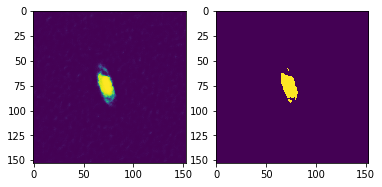

In [350]:
img, label = ds_eval.__getitem__(np.random.randint(ds_eval.__len__()))
with torch.no_grad():
    out = m(img.unsqueeze(0))
  
im = back_tf(out[0,0])
(t, segmentation) = cv2.threshold(im, 100, 255, cv2.THRESH_BINARY)
fig, ax = plt.subplots(1,2)
ax[0].imshow(im)
ax[1].imshow(segmentation)

0.21979573 0.999566 256.9815 1166.8116751413418
([], [0.22024248798892657], [False])


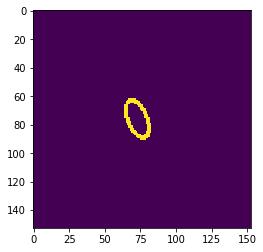

In [351]:
  
detection = detect_features(out,120)
print(detection)
prediction_image = cv2.cvtColor(back_tf(out[0,0]), cv2.COLOR_GRAY2RGB)

pred_ellipse, propabilities, labels = detection
if pred_ellipse:
    prediction_image=draw_ellipse(prediction_image, pred_ellipse, thickness=2, color=(255,0,0))
    
for el, p, label in zip(pred_ellipse, propabilities, labels):
    print(f"Ellipses@{el[0]}, with {p} and is borderchecker {label}")


Text(0.5, 1.0, 'prediction:')

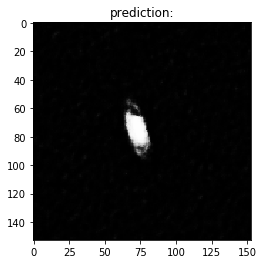

In [352]:
plt.imshow(prediction_image)
plt.title(f'prediction:')

In [ ]:
get_propability(out[0,0], largest_ellipse)